In [16]:
# Import library for model training
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)
tf.test.gpu_device_name()

# Data images processing - separate generators for train/val/test
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

# Validation and test data should only be rescaled, no augmentation
val_test_datagen = ImageDataGenerator(rescale=1/255.0)

# Create generator for each split, handling nested subfolders
def create_generator(datagen, split_paths, split_labels, batch_size=64, shuffle=True):
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    
    # Create a dataframe with file paths and labels
    df = pd.DataFrame({
        'filepath': split_paths,
        'label': split_labels
    })
    
    # Convert numeric labels to class names
    label_map = {
        0: 'with_mask',
        1: 'without_mask',
        2: 'incorrect_mask'
    }
    df['class'] = df['label'].map(label_map)
    
    return datagen.flow_from_dataframe(
        df,
        x_col='filepath',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle
    )

2.16.1


In [18]:
# Create generators for each split
train_generator = create_generator(train_datagen, train_paths, train_labels)
val_generator = create_generator(val_test_datagen, val_paths, val_labels, shuffle=False)
test_generator = create_generator(val_test_datagen, test_paths, test_labels, shuffle=False)

print("\nGenerator details:")
print(f"Training steps per epoch: {len(train_generator)}")
print(f"Validation steps per epoch: {len(val_generator)}")
print(f"Test steps: {len(test_generator)}")

Found 10175 validated image filenames belonging to 3 classes.
Found 1453 validated image filenames belonging to 3 classes.
Found 1453 validated image filenames belonging to 3 classes.
Found 2908 validated image filenames belonging to 3 classes.

Generator details:
Training steps per epoch: 159
Validation steps per epoch: 23
Test steps: 46
Found 2908 validated image filenames belonging to 3 classes.

Generator details:
Training steps per epoch: 159
Validation steps per epoch: 23
Test steps: 46


In [19]:
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Get all image file paths and labels recursively
data_dir = './FMD_DATASET'
classes = {
    'with_mask': ['complex', 'simple'],
    'without_mask': ['complex', 'simple'],
    'incorrect_mask': ['mc', 'mmc']
}
filepaths = []
labels = []

for label, (class_name, subfolders) in enumerate(classes.items()):
    class_dir = os.path.join(data_dir, class_name)
    for subfolder in subfolders:
        subfolder_path = os.path.join(class_dir, subfolder)
        if os.path.exists(subfolder_path):
            for fname in os.listdir(subfolder_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    filepaths.append(os.path.join(subfolder_path, fname))
                    labels.append(label)

filepaths = np.array(filepaths)
labels = np.array(labels)

if len(filepaths) == 0 or len(labels) == 0:
    print("No images found in the specified directories. Please check the data path and class folders.")
    # define empty variables to avoid NameError in later cells
    train_paths = temp_paths = val_paths = test_paths = np.array([])
    train_labels = temp_labels = val_labels = test_labels = np.array([])
else:
    # Split into train (70%), temp (30%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        filepaths, labels, test_size=0.3, stratify=labels, random_state=42
    )

    # Split temp into val (10%) and test (20%)
    val_size = 1/3  # 10/(10+20)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=2/3, stratify=temp_labels, random_state=42
    )

    print("Dataset split summary:")
    print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")
    
    # Print class distribution
    for split_name, split_paths, split_labels in [
        ("Train", train_paths, train_labels),
        ("Val", val_paths, val_labels),
        ("Test", test_paths, test_labels)
    ]:
        print(f"\n{split_name} set distribution:")
        unique, counts = np.unique(split_labels, return_counts=True)
        for label_idx, count in zip(unique, counts):
            class_name = list(classes.keys())[label_idx]
            print(f"  {class_name}: {count} images")

Dataset split summary:
Train: 10175, Val: 1453, Test: 2908

Train set distribution:
  with_mask: 3352 images
  without_mask: 3323 images
  incorrect_mask: 3500 images

Val set distribution:
  with_mask: 479 images
  without_mask: 474 images
  incorrect_mask: 500 images

Test set distribution:
  with_mask: 958 images
  without_mask: 950 images
  incorrect_mask: 1000 images


In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout

# Model design
based_model = MobileNetV2(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3))
based_model.trainable = False

model = Sequential()
model.add(based_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(3))  # สำหรับ 3 class
model.add(Activation('softmax'))
model.summary()

# Model optimizer
opt = Adam(learning_rate=0.001, decay=0.001 / 20)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,403 (9.27 MB)

 Trainable params: 172,419 (673.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

c:\Users\Asus\facemask_detection\facemask_detection\.venv\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [22]:
# Configure data augmentation parameters
augment_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create augmented generator for training data
train_generator_augmented = create_generator(augment_datagen, train_paths, train_labels, batch_size=32)

# Train the model with augmented data
history = model.fit(
    train_generator_augmented,
    validation_data=val_generator,
    epochs=50,
    batch_size=32,
    verbose=1
)

Found 10175 validated image filenames belonging to 3 classes.
Epoch 1/50
Epoch 1/50
 15/318 ━━━━━━━━━━━━━━━━━━━━ 4:58 987ms/step - accuracy: 0.4220 - loss: 1.1012

c:\Users\Asus\facemask_detection\facemask_detection\.venv\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


318/318 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.8873 - loss: 0.3006 - val_accuracy: 0.9553 - val_loss: 0.1229
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.8873 - loss: 0.3006 - val_accuracy: 0.9553 - val_loss: 0.1229
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.9399 - loss: 0.1801 - val_accuracy: 0.9491 - val_loss: 0.1350
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.9399 - loss: 0.1801 - val_accuracy: 0.9491 - val_loss: 0.1350
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.9495 - loss: 0.1537 - val_accuracy: 0.9621 - val_loss: 0.1107
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.9495 - loss: 0.1537 - val_accuracy: 0.9621 - val_loss: 0.1107
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.9545 - loss: 0.1430 - val_accuracy: 0.9649 - val_loss: 0.1063
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.9545 - loss: 0.1430 - val_accuracy: 0.964

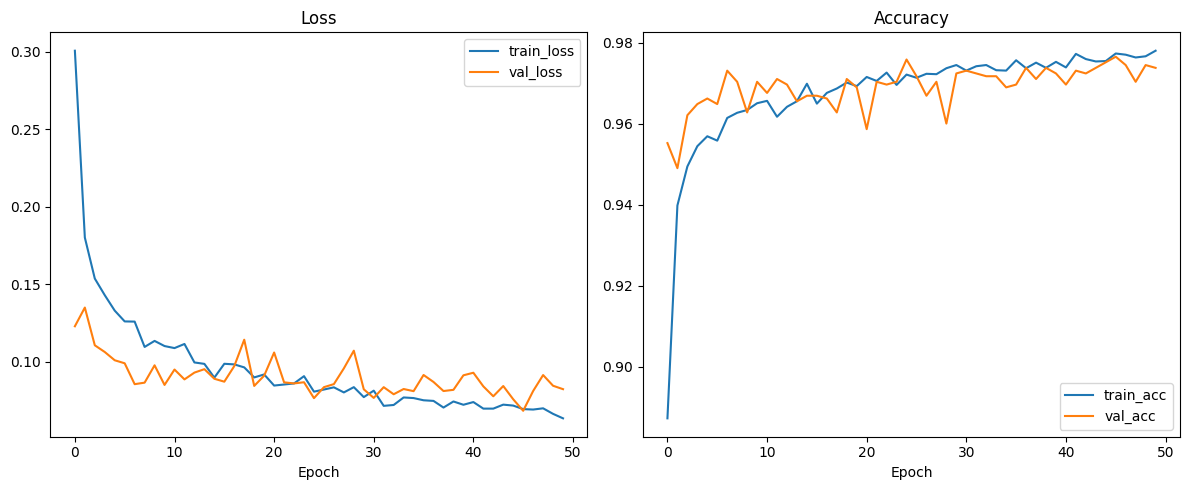

46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step


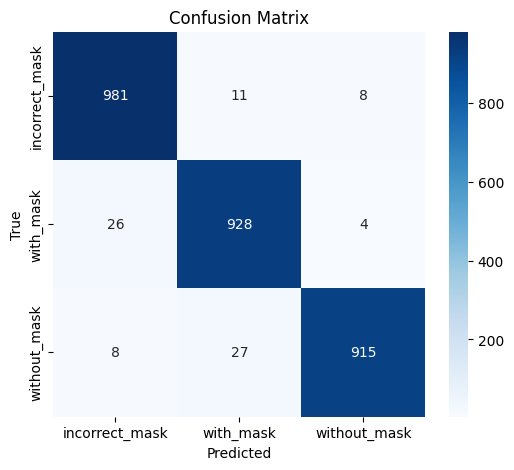

In [25]:
# Plot training history (loss + accuracy) and show confusion matrix on test set
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1) Plot loss & accuracy from history (if available)
if 'history' in globals():
    h = history.history
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(h.get('loss', []), label='train_loss')
    plt.plot(h.get('val_loss', []), label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1,2,2)
    # some TF versions use 'accuracy' others 'acc' keys; try both
    acc = h.get('accuracy', h.get('acc', []))
    val_acc = h.get('val_accuracy', h.get('val_acc', []))
    plt.plot(acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("history not found. Run the training cell to collect history before plotting.")

# 2) Confusion matrix and classification report on the test set
if 'test_generator' in globals():
    # ensure we use the full test set (generator should not be shuffled)
    steps = len(test_generator)
    # Predict on the entire test set
    preds = model.predict(test_generator, steps=steps, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    # True labels: prefer generator.classes if available
    if hasattr(test_generator, 'classes'):
        y_true = test_generator.classes
    else:
        # fallback: collect labels batch-wise (works for categorical y)
        y_list = []
        for _, yb in test_generator:
            if isinstance(yb, np.ndarray):
                y_list.append(yb)
            else:
                # if generator yields (x, y) as lists/tuples
                y_list.append(np.array(yb))
            # stop collecting when we've got enough samples
            if sum(a.shape[0] for a in y_list) >= test_generator.samples:
                break
        y_all = np.concatenate(y_list, axis=0)
        if y_all.ndim > 1:
            y_true = np.argmax(y_all, axis=1)
        else:
            y_true = y_all

    # Build class names in index order
    class_indices = test_generator.class_indices if hasattr(test_generator, 'class_indices') else None
    if class_indices is not None:
        inv_map = {v:k for k,v in class_indices.items()}
        class_names = [inv_map[i] for i in range(len(inv_map))]
    else:
        # default names if not available
        class_names = [str(i) for i in range(len(np.unique(y_true)))]

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()



Classification Report:
                precision    recall  f1-score   support

incorrect_mask       0.97      0.98      0.97      1000
     with_mask       0.96      0.97      0.96       958
  without_mask       0.99      0.96      0.97       950

      accuracy                           0.97      2908
     macro avg       0.97      0.97      0.97      2908
  weighted avg       0.97      0.97      0.97      2908



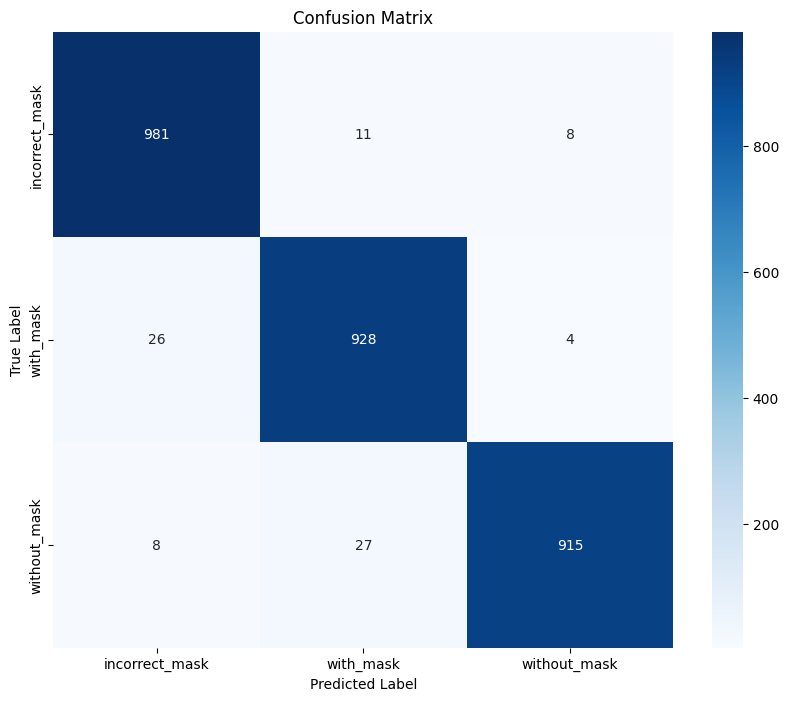

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate and display classification report (includes precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix with better visualization
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [26]:
# Save model
model.save('moblienet.h5')